# Diffusion-Super-Resolution-GAN

**Author(s):** Harvey Mannering [@harveymannering](https://github.com/harveymannering), Zhanxiang Sun [@seansunn](https://github.com/seansunn) and Miguel Xochicale [@mxochicale](https://github.com/mxochicale)

**Contributor(s):** 


## Introduction
This notebook presents training for Diffusion-Super-Resolution-GAN model.
The following notebook run on Google Colab.  If it's run on another platform you will need to run `pip install` or create a conda envirionment.

### Running notebook
Go to repository path: `cd $HOME/repositories/budai4medtech/midl2023/notebooks`   
Open repo in pycharm and in the terminal type:
```
git checkout master # or the branch
git pull # to bring a local branch up-to-date with its remote version
```
Launch Notebook server:
```
conda activate febusisVE
jupyter notebook --browser=firefox
```
which will open your web-browser.


### Logbook
* [DATE]: Short description of the update
* 31-May-2023: re-organise imports and tidied notebook 

### References
* [CVPR2017] Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network
https://openaccess.thecvf.com/content_cvpr_2017/html/Ledig_Photo-Realistic_Single_Image_CVPR_2017_paper.html
https://arxiv.org/abs/1609.04802
https://scholar.google.com/scholar?cites=1219263946448760936&as_sdt=2005&sciodt=0,5&hl=en



In [1]:
# !pip install --upgrade gdown
# !pip install -qq diffusers==0.12.1 datasets accelerate wandb open-clip-torch
# !pip install wandb
# !pip install monai
# !pip install torchmetrics[image]
# !pip install gdown

In [2]:
import os

from PIL import Image
from tqdm.auto import tqdm
import cv2
import numpy as np

import pandas as pd
import random
from tqdm.auto import tqdm
from skimage import io
import wandb
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
import scipy.ndimage
from scipy.linalg import sqrtm
from skimage import transform
from skimage.transform import resize

import matplotlib.pyplot as plt
from skimage.exposure import match_histograms
from csv import writer

import matplotlib.pyplot as plt
import math
import nibabel as nib #Read and write access to common neuroimaging file formats

import torch
import torch.optim as optim
from torch.autograd import Variable
import argparse
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn import Module
from torch.autograd import Variable

import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torchmetrics.image.fid import FrechetInceptionDistance

from diffusers import DDIMScheduler, DDPMPipeline, UNet2DModel

import monai.transforms as mt
from monai.utils import GridSampleMode, GridSamplePadMode, optional_import



In [3]:
HOME_PATH = os.path.expanduser(f'~')
USERNAME = os.path.split(HOME_PATH)[1]

REPOSITORY_PATH='repositories/datasets/FETAL_PLANES_ZENODO/'
FULL_REPO_DATA_PATH = HOME_PATH+'/'+REPOSITORY_PATH

image_dataroot = FULL_REPO_DATA_PATH + "Images/"
image_references = FULL_REPO_DATA_PATH + "FETAL_PLANES_DB_data.csv"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Printing Versions and paths
print(f'image_dataroot: {image_dataroot}' )
print(f'FETAL_PLANES_DB_data: {image_references}' )

print(f'Device: {device}')


image_dataroot: /home/mxochicale/repositories/datasets/FETAL_PLANES_ZENODO/Images/
FETAL_PLANES_DB_data: /home/mxochicale/repositories/datasets/FETAL_PLANES_ZENODO/FETAL_PLANES_DB_data.csv
Device: cuda:0


In [4]:
# # Download pretrained models (you will have to train the models yourself if these links are broken)
# !gdown https://drive.google.com/uc?id=1hdJvqR5VVGQ_lO9B5oGh3zHQfabhzPNc
# !gdown https://drive.google.com/uc?id=1-Bhf_6Q3WYsjm3y-exvAPJfb1TFyLyH7

In [5]:
# # Load the dataset
# !gdown https://drive.google.com/uc?id=1DLAUP47OOGJYBaVMI35kIVa-cNcLJinh
# !unzip /content/FETAL_PLANES_ZENODO.zip  -d /content/FETAL_PLANES_ZENODO

# Diffusion Model

Here we finetune a diffusion a model from [huggingface](https://huggingface.co/google/ddpm-celebahq-256) that was initally trained on images of faces.  This follows the [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) paper.  This will take several days to train.

In [6]:
class FetalPlaneDataset(Dataset):
    """Fetal Plane dataset."""

    def __init__(self, root_dir, ref, 
                 plane, 
                 brain_plane=None, 
                 us_machine=None, 
                 operator_number=None, 
                 transform=None,
                 train=True
                ):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            plane: 'Fetal brain'; 'Fetal thorax'; 'Maternal cervix'; 'Fetal femur'; 'Fetal thorax'; 'Other'
            brain_plane: 'Trans-ventricular'; 'Trans-thalamic'; 'Trans-cerebellum'
            us_machine: 'Voluson E6';'Voluson S10'
            operator_number: 'Op. 1'; 'Op. 2'; 'Op. 3';'Other'
            train: Flag denotes if test or train data is used

            
        return image
        """

        # Select which images in the dataset to use
        self.root_dir = root_dir
        self.ref = pd.read_csv(ref, sep=';')
        self.ref = self.ref[self.ref['Plane'] == plane]
        if plane == 'Fetal brain':
            self.ref = self.ref[self.ref['Brain_plane'] == brain_plane]
        if us_machine is not None:
            self.ref = self.ref[self.ref['US_Machine'] == us_machine]
        if operator_number is not None:
            self.ref = self.ref[self.ref['Operator'] == operator_number]

        # Limit dataset size to 256 images (for training)
        size = 256
        if train:
          self.ref = self.ref[:size]
        else :
          self.ref = self.ref[size:]
        self.transform = transform

    def __len__(self):
        return len(self.ref)

    def __getitem__(self, idx):
        # Load the image from file
        img_name = os.path.join(self.root_dir,
                                self.ref.iloc[idx, 0] + '.png')
        image = io.imread(img_name) #<class 'numpy.ndarray'>
        
        # Preprocess and augment the image
        if self.transform:
            image = self.transform(image)

        ## Make a half sized image for SRGAN
        downsampling = 2
        ds_image = resize(
                        image.cpu().numpy(), 
                        (image.shape[0], image.shape[1] / downsampling, image.shape[2] / downsampling)
                         )
                        #.cpu().numpy()#TypeError: Cannot interpret 'torch.float32' as a data type

        return ds_image, image

In [7]:
# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

###################################
## Plane
plane = 'Fetal brain'
# plane = 'Fetal thorax'
# plane = 'Maternal cervix'
# plane = 'Fetal femur'
# plane = 'Fetal thorax'
# plane = 'Other'

###################################
## Operator number 
operator_number = None
# operator_number = 'Op. 1'
# operator_number = 'Op. 2'
# operator_number = 'Op. 3'
# operator_number = 'Other'

###################################
## Ultrasound device 
# us_machine = None
# us_machine = 'Voluson E6'
# us_machine = 'Voluson S10'

###################################
## Brain plan and ultrasound device
# brain_plane = 'Trans-ventricular'; us_machine = 'Voluson E6' ###len: 408 
# brain_plane = 'Trans-ventricular';us_machine = 'Voluson S10' ###len: 59 
# brain_plane = 'Trans-ventricular'; us_machine = 'Aloka' ###len: 112 
# brain_plane = 'Trans-ventricular'; us_machine = 'Other' ###len: 18

# brain_plane = 'Trans-thalamic'; us_machine = 'Voluson E6' ###len: 1072 
# brain_plane = 'Trans-thalamic'; us_machine = 'Voluson S10' ###len: 123 
# brain_plane = 'Trans-thalamic'; us_machine = 'Aloka' ###len: 360 
# brain_plane = 'Trans-thalamic'; us_machine = 'Other' ###len: 83 

brain_plane = 'Trans-cerebellum'; us_machine = 'Voluson E6' ###len: 492 
# brain_plane = 'Trans-cerebellum'; us_machine = 'Voluson S10' ###len: 68 
# brain_plane = 'Trans-cerebellum'; us_machine = 'Aloka' ###len: 134 
# brain_plane = 'Trans-cerebellum'; us_machine = 'Other' ###len: 20 

image_size = 128

# Number of workers for dataloader
workers = 8

# Batch size during training
batch_size = 4
# batch_size = 8
# batch_size = 16
# batch_size = 128

# Data augmentation and preprocessing 
monai_transform_operations=transforms.Compose([
                        transforms.ToTensor(),
                        mt.RandRotate(range_x=0.1, prob=0.5),
                        mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        mt.RandFlip(prob=0.5, spatial_axis=1),
                        mt.Resize([image_size, image_size]),
                        transforms.Resize([image_size, image_size]),
                        transforms.Normalize(0.5, 0.5), #mean=0.5, std=0.5 
                        ])

# transform_operations=transforms.Compose([
#                         transforms.ToTensor(),
#                         transforms.RandomRotation(degrees=(0, 180)),
#                         transforms.RandomHorizontalFlip(p=0.5),
#                         transforms.RandomVerticalFlip(p=0.5),
#                         transforms.Resize([image_size, image_size], antialias=True),
#                         transforms.Normalize(0.5, 0.5), #mean=0.5, std=0.5 
#                         ])
# #https://pytorch.org/vision/0.9/transforms.html                    

# Define the dataset for fine tuning the DDPM
train_set = FetalPlaneDataset(root_dir=image_dataroot,
                            ref=image_references,
                            plane=plane,
                            brain_plane=brain_plane,
                            us_machine=us_machine,
                            operator_number=operator_number,
                            transform=monai_transform_operations
                            #transform=transform_operations
                            )

train_size = 12
#train_size = 64



number_of_images = train_set.__len__()
print(f'length {number_of_images}')

train_set_dataloader = DataLoader(train_set, 
                        batch_size=batch_size,
                        shuffle=True, 
                        num_workers=workers)

## Print dataloader features
#print(type(train_set_dataloader)) # <class 'torch.utils.data.dataloader.DataLoader'>
real_batch = next(iter(train_set_dataloader)) 
#print(type(real_batch)) # <class 'list'>


Random Seed:  999
length 256


/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/monai/data/__init__.py:120: UserWarning: TypedStorage is deprecated. It will be removed in the future and Un

In [8]:
# Turn this on for extra debuging information, but you need a weights and biases account
wandb_enabled = False

if wandb_enabled:
  # start a new wandb run to track this script
  wandb.init(
    # set the wandb project where this run will be logged
    project="fetal-brain-diffusion",
    # track hyperparameters and run metadata
    config={
    "architecture": "CNN",
    "dataset": "Fetal Plane dataset",
    }
  )
  wandb.log({"Started" : 1})

# Download pre trained diffusion model from hugginface
print("Downloading Models")
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device);
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)

## Hyperparameters
#num_epochs = 20001
num_epochs = 2

#channels = 1
#channels = 3

lr = 1e-4  
grad_accumulation_steps = 8

# Define optimization algorithm
optimizer = torch.optim.Adam(image_pipe.unet.parameters(), lr=lr)

# Loss history
losses = []

# Static noise
x_noise = torch.randn(batch_size, 3, int(image_size), int(image_size)).to(device) # torch.Size([4, 3, 128, 128])
x_noise = x_noise.to(device)

# Setup FID metric
fid = FrechetInceptionDistance(feature=192).to('cuda')

print("Starting Training")
for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_set_dataloader), total=len(train_set_dataloader)):
        # Get an uncorrupted image
        clean_images = batch[1].to(device)
        clean_images = torch.cat((clean_images, clean_images, clean_images), dim=1)
        
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]
        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            image_pipe.scheduler.num_train_timesteps,
            (bs,),
            device=clean_images.device,
        ).long()
        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)
        #print(noisy_images.shape) #torch.Size([4, 3, 128, 128])
   
        # Get the model prediction for the noise
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]
        #print(noise_pred.shape) #torch.Size([4, 3, 128, 128])
           
        
        # Compare the prediction with the actual noise:
        loss = F.mse_loss(
            noise_pred, noise
        )  # NB - trying to predict noise (eps) not (noisy_ims-clean_ims) or just (clean_ims)

        # Store for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward(loss)

        # Gradient accumulation:
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()


    # Output the average loss for a given epoch
    print(
        f"Epoch {epoch} average loss: {sum(losses[-len(train_set):])/len(train_set)}"
    )
    if wandb_enabled:
      wandb.log({"Loss" : sum(losses[-len(train_set):])/len(train_set)})

    # Outputs an image and FID score to www.wandb.ai
    if wandb_enabled:
      if epoch % 100 == 0: 
        x = torch.clone(x_noise)
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            model_input = scheduler.scale_model_input(x, t)
            with torch.no_grad():
                noise_pred = image_pipe.unet(model_input, t)["sample"]
            x = scheduler.step(noise_pred, t, x).prev_sample

        images = wandb.Image(np.transpose(x[0,...].detach().cpu().numpy(), (1,2,0)), caption="Top: Output, Bottom: Input")
        wandb.log({"DiffusionImage": images})
    # Save models and optimiser state every 1000 epochs
    if epoch % 1000 == 0: 
      torch.save(image_pipe.unet.state_dict(), '128xfetal_' + str(epoch) + '.pth')
      torch.save(optimizer.state_dict(), '128x_optim_fetal_' + str(epoch) + '.pth')


Starting Training


  0%|          | 0/64 [00:00<?, ?it/s]

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

Epoch 0 average loss: 0.005930149401137896


  0%|          | 0/64 [00:00<?, ?it/s]

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

Epoch 1 average loss: 0.010310834276879177


# SRGAN

Here we train SRGAN ([Super Resolution GAN](https://arxiv.org/abs/1609.04802)) from scratch.  This is used to upscale a $128 \times 128$ image to a $256 \times 256$ image ($128 \times 128 \rightarrow 256 \times 256$). This will take a few hours to complete with a decent GPU.

In [9]:
image_size = 12
# image_size = 28
# image_size = 256

# Number of workers for dataloader
workers = 8

# Batch size during training
batch_size = 1
# batch_size = 8
# batch_size = 16
# batch_size = 128

# Define the augmented dataset for SRGAN's training
transform_operations=transforms.Compose([
                        transforms.ToTensor(),
                        mt.RandRotate(range_x=0.1, prob=0.5),
                        mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        mt.RandFlip(prob=0.5, spatial_axis=1),
                        transforms.Resize([image_size, image_size]),
                        transforms.Normalize(0.5, 0.5), #mean=0.5, std=0.5 
                        ])

dataset = FetalPlaneDataset(root_dir=image_dataroot,
                            ref=image_references,
                            plane=plane,
                            brain_plane=brain_plane,
                            us_machine=us_machine,
                            operator_number=operator_number,
                            transform=transform_operations)

number_of_images = dataset.__len__()
print(f'length {number_of_images}')

dataloader = DataLoader(dataset, 
                        batch_size=batch_size,
                        shuffle=True, 
                        num_workers=workers)

aug_images = next(iter(dataloader))
aug_images = (aug_images[1] + 1) * 127.5
aug_images = aug_images.to(device)
aug_images = torch.cat((aug_images,aug_images,aug_images), axis=1)

# Define unaugmented dataset
transform_ops=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size]),
                        transforms.Normalize(0.5, 0.5), #mean=0.5, std=0.5 
                        ])
original_dataset = FetalPlaneDataset(root_dir=image_dataroot,
                            ref=image_references,
                            plane=plane,
                            brain_plane=brain_plane,
                            us_machine=us_machine,
                            operator_number=operator_number,
                            transform=transform_ops,
                            train=False)

original_dataloader = DataLoader(original_dataset, 
                        batch_size=64,
                        shuffle=True, 
                        num_workers=workers)
original_images = next(iter(original_dataloader))
original_images = (original_images[1] + 1) * 127.5
original_images = original_images.to(device)
original_images = torch.cat((original_images,original_images,original_images), axis=1)




length 256


/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [10]:

# -- Degradation function --
# The degradation function is responsible for transforming high-resolution images into the
# low resolution training images
# degradation function used here is again chosen to be faithful to ESPCN paper (blur and subsample)
def degradation(hr_image, factor):
    blurred = scipy.ndimage.gaussian_filter(hr_image, sigma=0.35*factor)
    lr_image = blurred[::factor, ::factor, ::factor]
    return lr_image

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(x)
        residual = self.prelu(x)
        residual = self.conv2(x)
        residual = self.bn2(x)

        return x + residual

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, upscale):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels * upscale ** 2, kernel_size=3, padding=1)
        self.pix_shuffle = nn.PixelShuffle(upscale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.pix_shuffle(x)
        x = self.prelu(x)
        return x

class Generator(nn.Module):
    def __init__(self, scale_factor):
        super().__init__()
        upsample_block_num = int(math.log(scale_factor, 2))

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )

        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        
        block8 = [UpsampleBlock(64, 2) for _ in range(upsample_block_num)]
        block8.append(nn.Conv2d(64, 1, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)

    def forward(self, x):
        b1 = self.block1(x)
        b2 = self.block2(b1)
        b3 = self.block3(b2)
        b4 = self.block4(b3)
        b5 = self.block5(b4)
        b6 = self.block6(b5)
        b7 = self.block7(b6)
        b8 = self.block8(b1+b7)
        return torch.tanh(b8)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )
        
    def forward(self, x):
        batch_size = x.size()[0]
        return torch.sigmoid(self.net(x).view(batch_size))

class TotalVariationLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super().__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]

        count_h = self.tensor_size(x[:,:,1:,:])
        count_w = self.tensor_size(x[:,:,:,1:])

        h_tv = torch.pow(x[:,:,1:,:] - x[:,:,:h_x-1,:], 2).sum()
        w_tv = torch.pow(x[:,:,:,1:] - x[:,:,:,:w_x-1], 2).sum()

        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]

class GeneratorLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TotalVariationLoss()

    def forward(self, out_labels, out_images, target_images):
        adversarial_loss = torch.mean(1 - out_labels)
        perception_loss = self.mse_loss(out_images, target_images)
        image_loss = self.mse_loss(out_images, target_images)
        tv_loss = self.tv_loss(out_images)
        return image_loss + 0.001 * adversarial_loss + 0.006 * perception_loss + 2e-8 * tv_loss
        

In [11]:
# Calculate the average colour distribution of the original dataset

image_size = 12
# image_size = 28
# image_size = 256

colour_keys = np.zeros((64,image_size,image_size))
for i in range(63):
  batch = next(iter(dataloader))
  real_img = batch[1]
  colour_key = real_img[0,...].detach().cpu().numpy()
  colour_key = colour_key.flatten()
  colour_key.sort()
  colour_key = colour_key.reshape(image_size,image_size)
  colour_keys[i,...] = colour_key
colour_key = np.mean(colour_keys, axis=0)
colour_key = np.stack((colour_key,colour_key,colour_key), axis=2)
colour_key = (colour_key + 1) * 127.5

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

In [12]:
# Load pretrained models 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load DDPM
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device);
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=100)
image_pipe.unet.load_state_dict(torch.load("128xfetal_0.pth" ))
# 128xfetal_10000

# # Load SRGAN
# upscale_factor = 2
# netG = Generator(upscale_factor)
# netG.load_state_dict(torch.load("SRGAN_G_x256_10.pth"))
# netG = netG.to(device)
# #FileNotFoundError: [Errno 2] No such file or directory: 'SRGAN_G_x256_10.pth'

<All keys matched successfully>

Start


/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/mxochicale/miniconda3/envs/medisynVE/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change

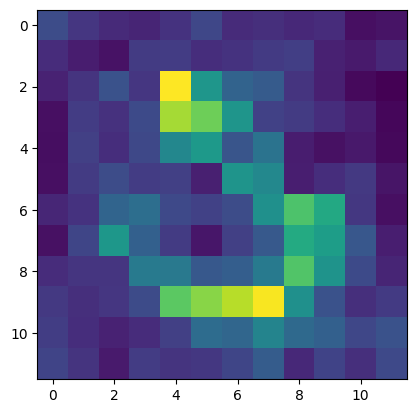

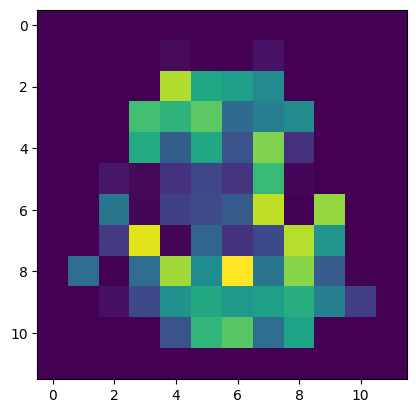

Epoch 0
 Generator Loss:24.265398690477014, Disciminator Loss:234.03382240980864
torch.Size([1, 3, 6, 6])
torch.Size([])


RuntimeError: Calculated padded input size per channel: (2 x 2). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

In [18]:
# Define models and hyperparameters
upscale_factor = 2
netG = Generator(upscale_factor)
netD = Discriminator()
generator_loss = GeneratorLoss()
generator_loss = generator_loss.to(device)
netG = netG.to(device)
netD = netD.to(device)
loss = nn.MSELoss()


channels = 3
num_epochs = 2
# num_epochs = 201

# Optimisers
optimiserG = optim.Adam(netG.parameters(), lr=0.0002)
optimiserD = optim.Adam(netD.parameters(), lr=0.0002)

# Setup FID metric
fid = FrechetInceptionDistance(feature=192).to('cuda')

# Write column headers to loss csv
with open('sr_gan_loss.csv', 'w') as f_object:
    writer_object = writer(f_object)
    writer_object.writerow(['Epoch', 'Generator_Loss', 'Disciminator_Loss', 'FID'])
    f_object.close()

eval_noise = torch.randn(64, channels, int(image_size / 2), int(image_size / 2)).to(device) # noise

# Training loop
print("Start")
for epoch in range(num_epochs):
    total_g_loss = 0
    total_d_loss = 0
    for data in dataloader:
        # Get data
        img = Variable(data[0])
        targ = Variable(data[1])
        img = img.to(device).float()
        targ = targ.to(device).float()

        # Discriminator
        fake = netG(img)
        targ = targ[0:fake.shape[0], 0:fake.shape[1], 0:fake.shape[2], 0:fake.shape[3]]
        netD.zero_grad()
        real_out = netD(targ.float()).mean()
        fake_out = netD(fake.float()).mean()
        d_loss = 1 - real_out.float() + fake_out.float()
        d_loss.backward(retain_graph = True)
        optimiserD.step()

        # Generator
        fake = netG(img).float()
        fake_out = netD(fake).mean()
        netG.zero_grad()
        g_loss = generator_loss(fake_out.float(), fake.float(), targ.float())
        g_loss.backward()
        fake = netG(img.float())
        fake_out = netD(fake.float()).mean()
        optimiserG.step()

        # calculate overall loss
        total_g_loss = total_g_loss + g_loss.item()
        total_d_loss = total_d_loss + d_loss.item()

    # Plot an example images for each epoch
    plt.imshow(fake[0,0,...].detach().cpu().numpy())
    plt.show()
    plt.imshow(targ[0,0,...].detach().cpu().numpy())
    plt.show()

    # Print average losses per epoch
    print("Epoch " + str(epoch))
    print(" Generator Loss:" + str(total_g_loss) + ", Disciminator Loss:" + str(total_d_loss))

    # Write loss csv
    current_fid = ""
    if epoch % 10 == 0:
        fake_images = np.zeros((64, channels, image_size, image_size))
        for it in range(64):
            # Define noise
            x_noise = eval_noise[it:it+1,...] # noise
            x_noise = x_noise.to(device)
            # Generate 128x128 image using DDPM
            x = torch.clone(x_noise)
            for i, t in enumerate(scheduler.timesteps):
                model_input = scheduler.scale_model_input(x, t)
                print(model_input.shape)#torch.Size([1, 3, 6, 6])
                print(t.shape)
                with torch.no_grad():
                    noise_pred = image_pipe.unet(model_input, t)["sample"]
                x = scheduler.step(noise_pred, t, x).prev_sample
            image = x 

            # Upscale fom 128x128 to 256x256 using SRGAN
            image = image.to(device)
            image = torch.mean(image, axis=1, keepdim=True)

            # Recolour image
            image = image.detach().cpu().numpy()
            image = image[0,0,...]
            image = np.stack((image,image,image), axis=0)
            image = np.transpose(image, (1,2,0))
            image = (image + 1) * 127.5
            matched = match_histograms(image, colour_key)
            matched = np.transpose(matched, (2,0,1))
            matched = np.expand_dims(matched, axis=0)
            matched = torch.from_numpy(matched)
            matched = matched.to(device)
            matched = torch.mean(matched, axis=1, keepdim=True)
            matched = (matched / 127.5) - 1
            sr_img = netG(matched.float())
            sr_img = sr_img.detach().cpu().numpy()

            # Upscale with super resolution
            sr_img = sr_img[0,0,...]
            sr_img = np.stack((sr_img,sr_img,sr_img), axis=0)
            sr_img = np.transpose(sr_img, (1,2,0))
            sr_img = (sr_img + 1) * 127.5
            fake_images[it,...] = np.transpose(sr_img, (2,0,1))
        # Calculate FID score using unaugmented images and fake images
        fake_images = torch.from_numpy(fake_images)
        fake_images = fake_images.to(device)
        fid.update(original_images.byte(), real=True)        
        fid.update(fake_images.byte(), real=False)
        current_fid = fid.compute().item()


        # Save model weights
        torch.save(netG.state_dict(), "SRGAN_G_x256" + str(epoch))
              
    # Write loss/FID to a log file for each epoch
    with open('sr_gan_loss.csv', 'a') as f_object:
        writer_object = writer(f_object)
        writer_object.writerow([str(epoch),  str(total_g_loss / 236), str(total_d_loss / 236), str(current_fid)])
        f_object.close()
    fid.reset()

    # Save model and optimiser weights
    torch.save(netD.state_dict(), "SRGAN_D_x256")
    torch.save(optimiserG.state_dict(), "SRGAN_optimiserG_x256")
    torch.save(optimiserD.state_dict(), "SRGAN_optimiserD_x256")


# Inference

Generating images has the following pipeline:
1. DDPM $(128 \times 128)$
2. Histogram matching $(128 \times 128)$
3. SRGAN $(128 \times 128 \rightarrow 256 \times 256)$ 


Step 2 adjusts the colours using histogram matching.  This involves matching the colour distribution of the generated images with the colour distribution of the original dataset.

In [ ]:
for it in range(64):
  # Define noise
  print(it)
  image_size = 256
  x_noise = torch.randn(1, 3, int(image_size / 2), int(image_size / 2)).to(device) # noise
  x_noise = x_noise.to(device)

  # Generate 128x128 image using DDPM
  x = torch.clone(x_noise)
  for i, t in tqdm(enumerate(scheduler.timesteps)):
      model_input = scheduler.scale_model_input(x, t)
      with torch.no_grad():
          noise_pred = image_pipe.unet(model_input, t)["sample"]
      x = scheduler.step(noise_pred, t, x).prev_sample
  image = x 

  # Reduce 3 channels to 1
  image = image.to(device)
  image = torch.mean(image, axis=1, keepdim=True)


  # Recolour image
  image = image.detach().cpu().numpy()
  image = image[0,0,...]
  image = np.stack((image,image,image), axis=0)
  image = np.transpose(image, (1,2,0))
  image = (image + 1) * 127.5
  matched = match_histograms(image, colour_key)
  matched = np.transpose(matched, (2,0,1))
  matched = np.expand_dims(matched, axis=0)
  matched = torch.from_numpy(matched)
  matched = matched.to(device)
  matched = torch.mean(matched, axis=1, keepdim=True)
  matched = (matched / 127.5) - 1

  # upscale with super resolution model
  sr_img = netG(matched.float())
  sr_img = sr_img.detach().cpu().numpy()
  sr_img = sr_img[0,0,...]
  sr_img = np.stack((sr_img,sr_img,sr_img), axis=0)
  sr_img = np.transpose(sr_img, (1,2,0))
  sr_img = (sr_img + 1) * 127.5


  # Show image
  plt.imshow(sr_img/255)
  plt.show()
  # Save image
  cv2.imwrite('Fake' + str(it) + '.png', sr_img) 

In [ ]:
# Save unaugmented original image
for it in range(64):
  org_im = original_images[it,...]
  org_im = org_im.detach().cpu().numpy()
  org_im = np.transpose(org_im, (1,2,0))

  # Show image
  plt.imshow(org_im/255)
  plt.show()
  # Save image
  cv2.imwrite('RealUnaugmented' + str(it) + '.png', org_im) 

